In [1]:
import os
import sqlite3
import datetime
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [37]:
#Read long term data from APSIM
con = sqlite3.connect(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\0. Long Term\Sorghum_long_term.db')
Harvest = pd.read_sql("Select * from HarvestReport",con)

#Read the Simulations table that has SimulationID matched to Simulation Name
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
#Add SimulationName column
Harvest.loc[:,'SimulationName'] = [Simulations.loc[Harvest.loc[x,'SimulationID'],'Name'] for x in Harvest.index]
Harvest.set_index('SimulationID',inplace=True)
Harvest.drop_duplicates(inplace=True)
#Drop some columns
df=Harvest.drop(['CheckpointID','Zone','AGBiomass', 'AGBiomassOM','FloweringDAS', 'MaturityDAS','Stage'],axis=1)
#Make some new columns
df['climate'] = df['SimulationName'].str[:6]
df['soil'] = df['SimulationName'].str[7:11]
df['cultivar'] = df['SimulationName'].str[12:15]

In [65]:
df=df.reset_index()

In [195]:
#Calculate statistics
sorted_mean = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).mean().round(1)
sorted_sd = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).std().round(1)
cv = (sorted_sd/sorted_mean*100).sort_values(ascending=False).round(1)

#Order cv accordingly with mean ascending order
reorderlist = ['Terang','Elliot','459100','429085','458099','431086','460100','430085','380074']
sorted_cv=cv.reindex(reorderlist)

No handles with labels found to put in legend.


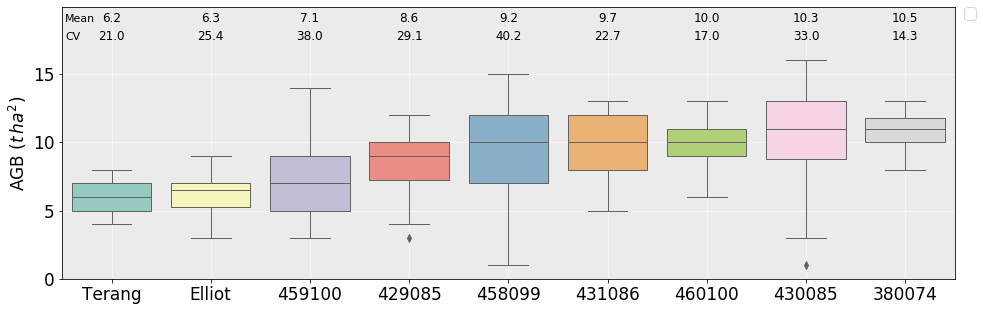

In [268]:
fig= plt.figure(figsize=(16,5))

# Apply order accordingly with mean yield
grouped = df.groupby("climate")
sorted_average = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).mean().sort_values(ascending=True)
#Graph
ax=sns.boxplot(x="climate", y="AGB", data=df, palette="Set3", linewidth=1, order=sorted_average.index)
    
# Formatting graph and background
plt.legend(prop=dict(size=16),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('AGB ($t\,ha^{2}$)', fontsize =17)
plt.xlabel('', fontsize =17)

ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
ax.set_ylim([0,19.9])
#plt.savefig('mint.png', dpi=1200)

#Specify mean
def parse(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

df['AGB'] = df['AGB'].apply(parse)
yposlist = df.groupby(['climate'])['AGB'].median().tolist()

y2=18.8
xposlist = range(len(yposlist))
stringlist=[sorted_average[0].round(1), sorted_average[1].round(1), sorted_average[2].round(1), sorted_average[3].round(1),
            sorted_average[4].round(1), sorted_average[5].round(1), sorted_average[6].round(1), sorted_average[7].round(1), 
            sorted_average[8].round(1)]

for i in range(len(stringlist)):
    ax.text(xposlist[i],y2,stringlist[i],horizontalalignment='center',size='large',color='k',weight='light')

#Specify cv
def parse(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

df['AGB'] = df['AGB'].apply(parse)
yposlist = df.groupby(['climate'])['AGB'].median().tolist()

y2=17.5
xposlist = range(len(yposlist))
stringlist=[sorted_cv[0], sorted_cv[1], sorted_cv[2], sorted_cv[3], sorted_cv[4], sorted_cv[5], sorted_cv[6], sorted_cv[7], sorted_cv[8]]

for i in range(len(stringlist)):
    ax.text(xposlist[i],y2,stringlist[i],horizontalalignment='center',size='large',color='k',weight='light')
    
plt.text(-0.47, 18.8, 'Mean',fontsize=11,color='k')
plt.text(-0.47, 17.5, 'CV',fontsize=11,color='k')

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\yieldvsclimate.png', dpi=300,bbox_inches='tight')

In [235]:
#Dataframe with mean and cv
mean = pd.DataFrame([sorted_average]).transpose().round(1)
mean=mean.reset_index()
cv = pd.DataFrame([sorted_cv]).transpose().round(1)
cv=cv.reset_index()
summ=pd.merge(mean, cv, on=['index'])
summ.rename(columns={'index':'climate','0_x':'mean','0_y':'cv'}, inplace=True)
summ

,climate,mean,cv
0,Terang,6.2,21.0
1,Elliot,6.3,25.4
2,459100,7.1,38.0
3,429085,8.6,29.1
4,458099,9.2,40.2
5,431086,9.7,22.7
6,460100,10.0,17.0
7,430085,10.3,33.0
8,380074,10.5,14.3


In [238]:
df['rain_ETo'] = df['rain']/df['potentialET']

<Figure size 360x360 with 0 Axes>

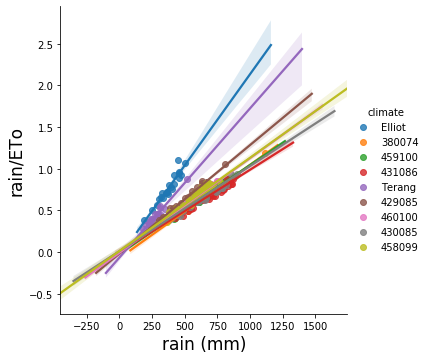

In [267]:
fig = plt.figure(figsize=(5,5))

sns.lmplot(x="rain", y="rain_ETo",hue='climate', data=df,ci=95)
# Formatting graph and background
plt.ylabel('rain/ETo', fontsize =17)
plt.xlabel('rain (mm)', fontsize =17)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\rain_ETo.png', dpi=300,bbox_inches='tight')

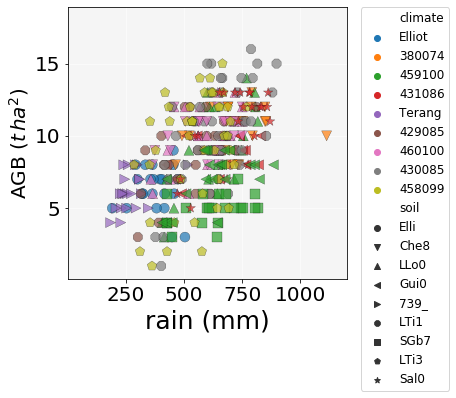

In [278]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
kwargs  =   {'edgecolor':"k"}

fig = plt.figure(figsize=(5,5))

ax=plt.subplot(1, 1, 1)

sns.scatterplot(x="rain", y="AGB",hue="climate",style="soil",s=100, alpha=0.7, data=df,linewidth=0.3,**kwargs,
                markers=filled_markers)

# Formatting graph and background
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('AGB ($t\,ha^{2}$)', fontsize =20)
plt.xlabel('rain (mm)', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(250))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1,1199])
ax.set_ylim([0.1,18.9])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\agbVSrain.png', dpi=300,bbox_inches='tight')